In [2]:
import pandas as pd
import regex as re
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_coupe = pd.read_csv('car_list_coupe.csv')
df_sedan = pd.read_csv('car_list_sedan.csv')
df_crossover = pd.read_csv('car_list_crossover.csv')
df_pickup = pd.read_csv('car_list_pickup.csv')

In [4]:
df = df_coupe.append(df_sedan).append(df_crossover).append(df_pickup).reset_index()

In [5]:
df['year'] = df['year-make'].map(lambda x: int(x[:4]))
df['torque'] = df['Torque (ft-lbs)'].dropna().map(lambda x: int(x[:x.find('t')-1]))
df['hrs_pwr'] =df['Horsepower'].dropna().map(lambda x: int(x[:x.find(' ')]))
df['mpg_city'] = df['MPG'].dropna().map(lambda x: int(x[:x.find(' ')]))
df['mpg_hwy'] = df['MPG'].dropna().map(lambda x: int(re.sub('[a-zA-Z\ ]|\(([0-9a-zA-Z])*\)','',x[x.find('/')+2:])))
df['log_mpg_hwy'] = np.log(df.mpg_hwy)
df['make'] = df['year-make'].map(lambda x: x[x.find(' ')+1:])
df = df.join(pd.get_dummies(df.make, drop_first = True))

In [6]:
cols = ['Curb Weight','Driver Head Room','Driver Leg Room','Fuel Capacity','Wheelbase','price', 'miles','torque']

In [7]:
for col in cols:
    print(col)
    df[col] = df[col].dropna().map(lambda x: x if type(x) == float else re.sub("[a-z,\$\*\"\ ]",'',x.replace('K','000')))
    df[col] = df[col].dropna().map(lambda x: np.nan if x == '' else float(x))

Curb Weight
Driver Head Room
Driver Leg Room
Fuel Capacity
Wheelbase
price
miles
torque


In [8]:
df['log_miles'] = np.log(df['miles'])
df['log_model_age'] = np.log(2022 - df['year'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       594 non-null    int64  
 1   Unnamed: 0                  594 non-null    int64  
 2   Curb Weight                 345 non-null    float64
 3   Dimensions                  325 non-null    object 
 4   Drive Type                  594 non-null    object 
 5   Driver Head Room            391 non-null    float64
 6   Driver Leg Room             391 non-null    float64
 7   Engine Type                 594 non-null    object 
 8   Exterior/Interior Color     594 non-null    object 
 9   Front Tire Size (standard)  393 non-null    object 
 10  Fuel Capacity               392 non-null    float64
 11  Horsepower                  391 non-null    object 
 12  MPG                         500 non-null    object 
 13  Number of Keys              0 non-n

<AxesSubplot:>

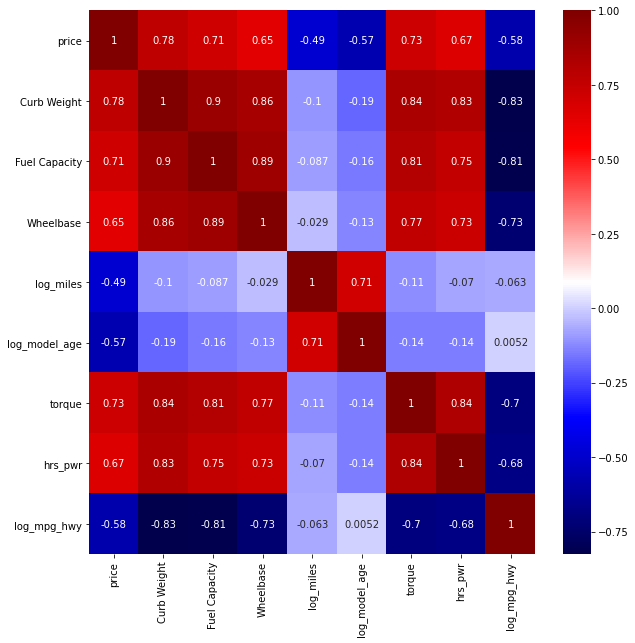

In [12]:
feats = ['price','Curb Weight','Fuel Capacity','Wheelbase','log_miles', 'log_model_age','torque','hrs_pwr','log_mpg_hwy']
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df[feats].corr(), cmap = 'seismic', annot = True)

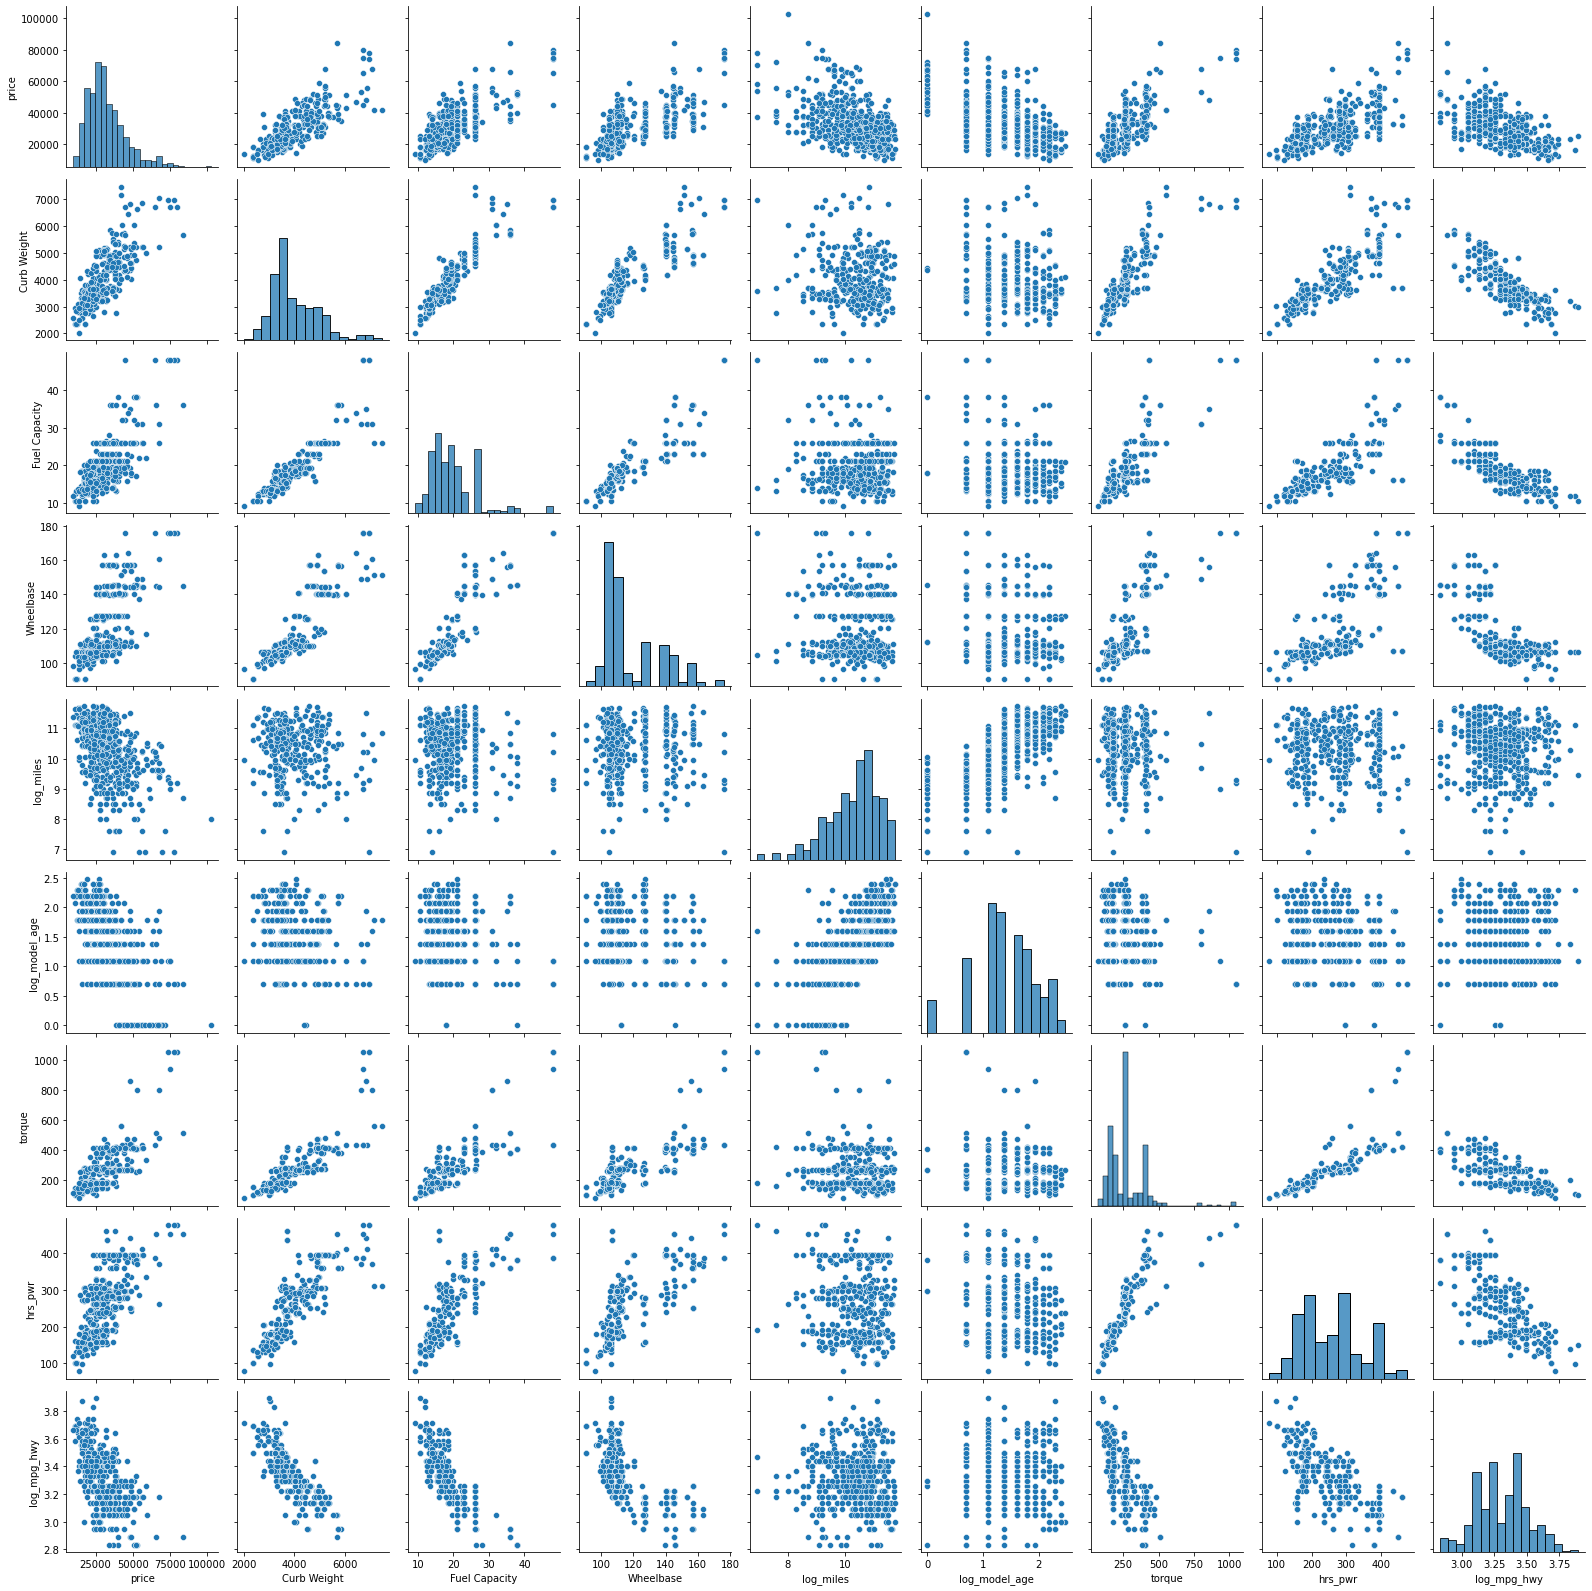

In [17]:
sns.pairplot(df[feats])

In [42]:
test_fit = df[['price','Curb Weight','log_miles']].dropna()

y_true = test_fit.price
x_true = test_fit[['log_miles', 'Curb Weight']]

x_miles = test_fit[['log_miles']]
x_wgt = test_fit[['Curb Weight']]

In [93]:
lm_fit = LinearRegression()
lm_t1 = LinearRegression()
lm_t2 = LinearRegression()

lm_fit.fit(x_true,y_true)
lm_score = lm_fit.score(x_true,y_true)

lm_t1.fit(x_miles,y_true)
t1_score = lm_t1.score(x_miles,y_true)

lm_t2.fit(x_wgt,y_true)
t2_score = lm_t2.score(x_wgt,y_true)

In [61]:
y_pred = lm_fit.predict(x_true)
y_pred_t1 = lm_t1.predict(x_miles)
y_pred_t2 = lm_t2.predict(x_wgt) 

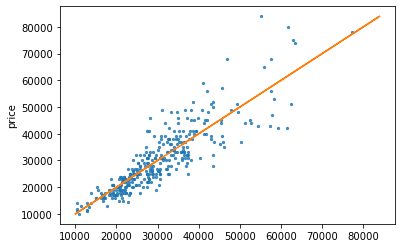

In [62]:
g1 = sns.regplot(x = y_pred, y = y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, scatter_kws={'s': 5})
g1.plot(y_true, y_true)

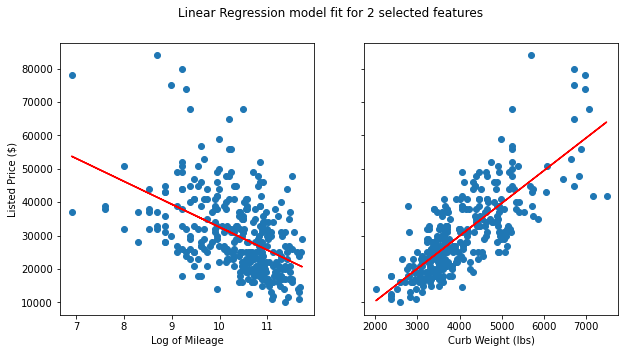

In [90]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
fig.suptitle('Linear Regression model fit for 2 selected features', )

axs[0].plot(x_miles, y_pred_t1, color = 'red')
axs[0].scatter(x_miles, y_true, marker = 'o',linewidths = 1)
axs[0].set_xlabel('Log of Mileage')

axs[1].plot(x_wgt, y_pred_t2, color = 'red')
axs[1].scatter(x_wgt, y_true, marker = 'o',linewidths = 1)
axs[1].set_xlabel('Curb Weight (lbs)')

for ax in axs.flat:
    ax.set(ylabel='Listed Price ($)')

for ax in axs.flat:
    ax.label_outer()
    
fig.savefig('../initial_feat_eval.png')

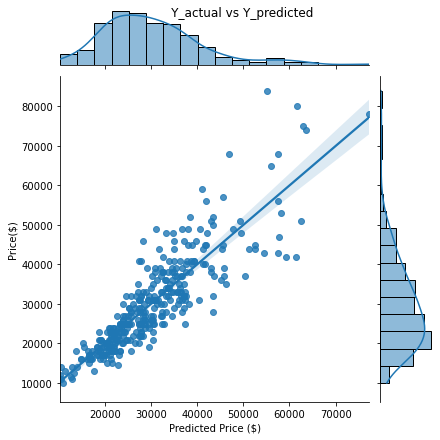

In [104]:
y_v_y = sns.jointplot(x=y_pred,y=y_true, kind='reg')
y_v_y.fig.suptitle('Y_actual vs Y_predicted')
y_v_y.set_axis_labels('Predicted Price ($)','Price($)')
y_v_y.savefig('../y_v_y.png')

In [53]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

MAE(y_true, y_pred)

4205.100206787883

In [54]:
RMSE(y_true, y_pred)

5890.219455545322

In [94]:
print(lm_score,' ',t1_score,' ',t2_score)

0.761914046217295   0.22934283547696033   0.6021315344827969
